<a href="https://colab.research.google.com/github/Nid989/IDAML2_Project/blob/master/idaml2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# set up the training class for transformer based models
# https://colab.research.google.com/drive/1dbvi4E5XbhAAwoPfZ0WUe5CQQ25YoSUW?authuser=2#scrollTo=PMrjy_0Q2rDb
# https://scikit-optimize.github.io/stable/auto_examples/plots/visualizing-results.html
# while designing the objective function use macro or micro f1 score as the hyperparameter uncertainity score for empirical risk minimization.

In [3]:
%%capture
!pip install transformers dataset evaluate sentencepiece seqeval scikit-optimize

In [4]:
%cd "/content/drive/MyDrive/IDAML2/"

/content/drive/.shortcut-targets-by-id/1-1GRWfNepkjzifBOSBHcluhZktVUQYFR/IDAML2


In [5]:
# !wget https://nlp.stanford.edu/data/glove.6B.zip -d "./"
# !unzip "./glove.6B.zip"

In [6]:
import os
import gc
import yaml
import pandas as pd
import numpy as np
import itertools
import typing
import logging
import functools
from tqdm.auto import tqdm
from datetime import datetime
from collections import defaultdict, OrderedDict, Counter
from typing import Dict, List, Tuple, Literal, Optional, Union

import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.checkpoint
import transformers
from transformers import (
    AutoTokenizer
)
from transformers.models.xlm_roberta.modeling_xlm_roberta import (
    XLMRobertaPreTrainedModel,
    XLMRobertaModel,
)
from dataclasses import dataclass
from transformers.modeling_utils import PreTrainedModel, unwrap_model
from transformers.modeling_outputs import TokenClassifierOutput
import evaluate

import torchtext

import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.callbacks import DeltaXStopper

from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")
dataset_types_ = Literal['BC5CDR', 'MultiCoNER2']
data_types_ = Literal['train', 'valid', 'test']
seqeval = evaluate.load("seqeval")
feature_extractor_types_ = Literal["lstm", "cnn"]

-----
##### Modeling

In [7]:
# ------------------------------------------- # Utility Methods # ------------------------------------------- #

In [47]:
def load_from_yaml(file_path):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
    return data

def save_skopt_results(results, filename: str="optimization_results.pkl", **kwargs):
    if "logging" in kwargs:
        kwargs["logging"].info("Saving the scikit-optimize (bayesian optimization) results w/ filename")
    skopt.dump(results, filename)

def load_skopt_results(filename: str="optimization_results.pkl"):
    return skopt.load("optimization_results.pkl")

def print_model_details(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {pytorch_total_params}")
    pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number of trainable parameters: {pytorch_total_trainable_params}")

def load_glove_embeddings(embedding_file, dimension):
    embeddings_index = {}
    with open(embedding_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Create a numpy array to store the embeddings
    embedding_matrix = np.zeros((len(embeddings_index), dimension))
    words_list = []

    for i, word in enumerate(embeddings_index):
        embedding_matrix[i] = embeddings_index[word]
        words_list.append(word)

    return embedding_matrix, words_list

In [9]:
# ------------------------------------------- # Dataset # ------------------------------------------- #

In [10]:
# ------------------------------------------- # BC5CDR Dataset # ------------------------------------------- #

In [11]:
class BC5CDR:
    def __init__(self, path_to_data_dir: str, remove_IOB: bool=False):
        super().__init__()
        self.path_to_data_dir = path_to_data_dir
        self.remove_IOB = remove_IOB
        self._load_data()
        self._configure_labels()

    def _configure_labels(self):
        # BC5CDR coprus; define 2 distinct named entity types (i.e. `Diesease`, `Chemical`).
        self.types = self._get_entity_types()
        self.labels = list(itertools.chain.from_iterable([[f"{tag}-{label}" for tag in ['B', 'I']] for label in self.types] + [['O']]))
        self.labels2idx = dict(zip(self.labels, list(range(len(self.labels)))))
        self.idx2labels = dict((idx, label) for label, idx in self.labels2idx.items())

    def __str__(self):
        specifics = """BC5CDR dataset
Entity types: { $ENTITY_TYPES$ }
Train data: $TRAIN_DATA_SIZE$
Validation data: $VALID_DATA_SIZE$
Test data: $TEST_DATA_SIZE$"""
        specifics = specifics.replace("$ENTITY_TYPES$", ", ".join(self.types))
        specifics = specifics.replace("$TRAIN_DATA_SIZE$", str(self.train_data.shape[0]))
        specifics = specifics.replace("$VALID_DATA_SIZE$", str(self.valid_data.shape[0]))
        specifics = specifics.replace("$TEST_DATA_SIZE$", str(self.test_data.shape[0]))
        return specifics

    def _load_data(self):
        self.train_docs = self._read_data(filename="cdr_train.conll")
        self.valid_docs = self._read_data(filename="cdr_valid.conll")
        self.test_docs = self._read_data(filename="cdr_test.conll")

        self.train_data = pd.DataFrame(self.train_docs)
        self.valid_data = pd.DataFrame(self.valid_docs)
        self.test_data = pd.DataFrame(self.test_docs)

    def _read_data(self, filename: str) -> Dict[str, List[str]]:
        file_path = os.path.join(self.path_to_data_dir, filename)
        documents = defaultdict(list)
        with open(file_path, 'r') as file:
            current_doc_id = None
            tokens = []
            labels = []
            counter = 0
            for line in file:
                if line.startswith('# doc_id'):
                    if current_doc_id is not None:
                        documents['doc_id'].append(current_doc_id)
                        documents['tokens'].append(tokens)
                        documents['labels'].append(labels)
                    current_doc_id = int(line.split('=')[1].strip())
                    tokens = []
                    labels = []
                else:
                    parts = line.strip().split('\t')
                    if len(parts) == 2:
                        tokens.append(parts[0])
                        labels.append(parts[1].split('-')[-1] if self.remove_IOB else parts[1])
            # append the last documents
            if current_doc_id is not None:
                documents['doc_id'].append(current_doc_id)
                documents['tokens'].append(tokens)
                documents['labels'].append(labels)
        return documents

    def _get_entity_types(self) -> List[str]:
        types = ['Disease', 'Chemical']
        return types

In [12]:
# ------------------------------------------- # MultiCoNER2 Dataset # ------------------------------------------- #

In [13]:
class MultiCoNER2:
    def __init__(self, path_to_data_dir: str, lang: Optional[str]=None, remove_IOB: bool=False):
        super().__init__()
        self.path_to_data_dir = path_to_data_dir
        self.lang = None
        self.remove_IOB = remove_IOB
        self._validate_lang_attr(lang)
        self._load_data()
        self._configure_labels()

    def _validate_lang_attr(self, lang):
        languages_ = Literal["bn", "de", "en", "es", "fa", "fr", "hi", "it", "multi", "pt", "sv", "uk", "zh"]
        lang = "en" if lang is None else lang
        if lang not in typing.get_args(languages_):
            raise ValueError("The language specified as 'lang' is not considered valid.")
        else:
            super().__setattr__("lang", lang)

    def _configure_labels(self):
        # MultiCoNER2 dataset; define 33 distinct entity types
        self.types = self._get_entity_types()
        self.labels = list(itertools.chain.from_iterable([[f"{tag}-{label}" for tag in ["B", "I"]] for label in self.types] + [["O"]]))
        self.labels2idx = dict(zip(self.labels, list(range(len(self.labels)))))
        self.idx2labels = dict((idx, label) for label, idx in self.labels2idx.items())

    def __str__(self):
        specifics = """MultiCoNER dataset
Entity types: { $ENTITY_TYPES$ }
Train data: $TRAIN_DATA_SIZE$
Validation data: $VALID_DATA_SIZE$
Test data: $TEST_DATA_SIZE$"""
        specifics = specifics.replace("$ENTITY_TYPES$", ", ".join(self.types))
        specifics = specifics.replace("$TRAIN_DATA_SIZE$", str(self.train_data.shape[0]))
        specifics = specifics.replace("$VALID_DATA_SIZE$", str(self.valid_data.shape[0]))
        specifics = specifics.replace("$TEST_DATA_SIZE$", str(self.test_data.shape[0]))
        return specifics

    def _load_data(self):
        self.train_docs = self._read_data(f"{self.lang}-train.conll")
        self.valid_docs = self._read_data(f"{self.lang}-dev.conll")
        self.test_docs = self._read_data(f"{self.lang}_test_withtags.conll")

        self.train_data = pd.DataFrame(self.train_docs)
        self.valid_data = pd.DataFrame(self.valid_docs)
        self.test_data = pd.DataFrame(self.test_docs)

        self.test_data = self.test_data.sample(n=10000, replace=False, random_state=42)

    def _read_data(self, filename: str) -> Dict[str, List[str]]:
            file_path = os.path.join(self.path_to_data_dir, filename)
            documents = defaultdict(list)
            with open(file_path, "r") as file:
                current_doc_id = None
                tokens = []
                labels = []
                counter = 0
                for line in file:
                    if line.startswith("# id"):
                        if current_doc_id is not None:
                            documents["doc_id"].append(current_doc_id)
                            documents["tokens"].append(tokens)
                            documents["labels"].append(labels)
                        current_doc_id = line.split(" ")[2].strip()
                        tokens = []
                        labels = []
                    else:
                        parts = line.strip().split()
                        if len(parts) == 4:
                            tokens.append(parts[0])
                            labels.append(parts[-1].split("-")[-1] if self.remove_IOB else parts[-1])
                # append the last documents
                if current_doc_id is not None:
                    documents["doc_id"].append(current_doc_id)
                    documents["tokens"].append(tokens)
                    documents["labels"].append(labels)
            return documents

    def _get_entity_types(self) -> List[str]:
        # extract entity types from derived train data
        types = sorted(set([word.split("-")[-1] for word in itertools.chain.from_iterable(self.train_data["labels"]) if word != "O"])) + ["O"]
        # save_to_pickle(types, f"{self.lang}_entity_types.pkl")
        return types

In [14]:
# ------------------------------------------- # Dataset Utility Methods # ------------------------------------------- #

In [15]:
# ------------------------------------------- # NERDataset # ------------------------------------------- #

In [16]:
class NERDataset_lstm_cnn:
    def __init__(self, config: Dict, **kwargs):
        self.modeling_type = "lstm_cnn"
        self.dataset_name = config["DATASET_NAME"]
        self.use_glove = kwargs["use_glove"] if "use_glove" in kwargs else config["USE_GLOVE"]
        self.rmv_stopwords = kwargs["rmv_stopwords"] if "rmv_stopwords" in kwargs else config["RMV_STOPWORDS"]
        self.lemmatize = kwargs["lemmatize"] if "lemmatize" in kwargs else config["LEMMATIZE"]
        # self.on_setup(**kwargs)
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        if self.use_glove:
            if "glove_dim" not in kwargs:
                raise AttributeError("Glove initialization requires the specification of embedding dimension!")
            else:
                glove_filename = "./glove.6B.{}d.txt".format(int(kwargs["glove_dim"]))
                self.glove_embeds, glove_vocab = load_glove_embeddings(glove_filename, dimension=int(kwargs["glove_dim"]))
                # There appears to be an issue with torchtext.vocab.vocab where it deletes the initial token in the vocabulary (OrderedDict);
                # therefore, we need to append an ignore token at the beginning.
                glove_vocab = ["<del>"] + glove_vocab
                glove_vocab_stoi = OrderedDict(dict(zip(glove_vocab, range(len(glove_vocab)))))
                self.vocab = torchtext.vocab.vocab(glove_vocab_stoi)
                self.vocab.insert_token("<pad>", 0)
                self.vocab.insert_token("<unk>", 1)
                self.vocab.set_default_index(0)
                self.vocab.set_default_index(1)
        else:
            self.vocab = self.prepare_vocab()

    def on_setup(self, **kwargs):
        if self.dataset_name == "BC5CDR":
            self.dataset = BC5CDR("./data/bc5cdr_data/")
        elif self.dataset_name == "MultiCoNER2":
            if "lang" not in kwargs:
                lang = "en"
                print("Selecting `en` as default value for attr. `lang` under MultiCoNER2")
            else:
                lang = kwargs["lang"]
            self.dataset = MultiCoNER2("./data/multiconer2_data/", lang=lang)
        else:
            raise ValueError(f"Invalid dataset-name provided, expected dataset-types are {dataset_types_}")

    def prepare_vocab(self):
        all_data = list(itertools.chain.from_iterable([getattr(self.dataset, f"{data_type}_data")["tokens"].values.tolist() \
                    for data_type in ["train", "valid"]]))
        if self.lemmatize:
            all_data = [[token.lemma_ for token in nlp(" ".join(instance))] for instance in all_data]
        _vocab = torchtext.vocab.build_vocab_from_iterator(all_data,
                                           specials=["<pad>", "<unk>"])
        return _vocab

    def preprocess_data(self, data_type: data_types_="train"):

        def _map_tokens_to_ids(instance: List[str]):
            return [self.vocab[token] if token in self.vocab else self.vocab["<unk>"] for token in instance]

        def _map_labels_to_ids(instance: List[str]):
            return [self.dataset.labels2idx[label] for label in instance]

        def _pad_sequence(sequence: List[int], max_length: int=150, padding_token_id: int=0):
            return sequence[:max_length] + [padding_token_id] * max(0, max_length - len(sequence))

        dataset_split = getattr(self.dataset, f"{data_type}_data")

        if self.rmv_stopwords:
            dataset_split["tokens"] = dataset_split.apply(
                lambda row: [token.text for token in nlp(" ".join(row["tokens"])) if not token.is_stop],
                axis=1
            )
        if self.lemmatize:
            dataset_split["tokens"] = dataset_split.apply(
                lambda row: [token.lemma_ for token in nlp(" ".join(row["tokens"]))],
                axis=1
            )
        setattr(self.dataset, f"{data_type}_data", dataset_split)

        model_inputs = dict()
        source = dataset_split["tokens"].values.tolist()
        target = dataset_split["labels"].values.tolist()
        sequence_length = dataset_split.apply(lambda row: len(row["tokens"]), axis=1).values.tolist()
        _pad_sequence_partial = functools.partial(_pad_sequence, max_length=150, padding_token_id=0)
        model_inputs["word_ids"] = list(map(_pad_sequence_partial, list(map(_map_tokens_to_ids, source))))
        _pad_sequence_partial = functools.partial(_pad_sequence, max_length=150, padding_token_id=-100)
        model_inputs["labels"] = list(map(_pad_sequence_partial, list(map(_map_labels_to_ids, target))))
        model_inputs["sequence_length"] = [torch.tensor(i) for i in sequence_length]

        model_inputs["word_ids"] = torch.tensor([i for i in model_inputs["word_ids"]], dtype=torch.long, device=self.device)
        model_inputs["labels"] = torch.tensor([i for i in model_inputs["labels"]], dtype=torch.long, device=self.device)
        model_inputs["sequence_length"] = torch.tensor([i for i in model_inputs["sequence_length"]], dtype=torch.long, device=self.device)
        model_inputs["mask"] = model_inputs["labels"].ne(0).int()
        return model_inputs

    def set_up_dataloader(self, data_type: data_types_="train", batch_size: int=2):
        dataset_split = self.preprocess_data(data_type=data_type)
        dataset_split = TensorDataset(dataset_split["word_ids"],
                                      dataset_split["labels"],
                                      dataset_split["sequence_length"],
                                      dataset_split["mask"])
        gc.collect()
        return DataLoader(dataset_split,
                          batch_size=batch_size,
                          shuffle=True)

In [17]:
class NERDataset_transformers:
    def __init__(self, tokenizer: AutoTokenizer, config: Dict, **kwargs):
        self.modeling_type = "transformers"
        self.dataset_name = config["DATASET_NAME"]
        self.tokenizer = tokenizer
        self.max_seq_len = kwargs["max_sequence_len"] if "max_sequence_len" in kwargs else config["MAX_SEQUENCE_LEN"]
        # NOTE: (callable under "__main__") on-set depends upon the whether we're implementing TokenClassification or TokenClassification w/ Linear Chain CRF.
        # self.on_setup(**kwargs)
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    def on_setup(self, **kwargs):
        if self.dataset_name == "BC5CDR":
            self.dataset = BC5CDR("./data/bc5cdr_data/")
        elif self.dataset_name == "MultiCoNER2":
            if "lang" not in kwargs:
                lang = "en"
                print("Selecting `en` as default value for attr. `lang` under MultiCoNER2")
            else:
                lang = kwargs["lang"]
            self.dataset = MultiCoNER2("./data/multiconer2_data/", lang=lang)
        else:
            raise ValueError(f"Invalid dataset-name provided, expected dataset-types are {dataset_types_}")

    def preprocess_data(self, data_type: data_types_="train"):
        dataset_split = getattr(self.dataset, f"{data_type}_data")

        source = [s for s in dataset_split["tokens"].values.tolist()]
        model_inputs = self.tokenizer(source,
                                      max_length=self.max_seq_len,
                                      padding="max_length",
                                      truncation=True,
                                      is_split_into_words=True)

        def synchronize_labels(dataset_split, model_inputs):
            """
            synchronize labels w.r.t tokenized model inputs
            """
            label_all_tokens = True
            NER_labels = []
            NER_labels_mask = []
            for index, label in enumerate(dataset_split["labels"].values.tolist()):
                word_ids = model_inputs.word_ids(batch_index=index)
                previous_word_idx = None
                label_ids = []
                label_masks = []
                for index2, word_idx in enumerate(word_ids):
                    if word_idx is None:
                        label_id = -100
                        label_ids.append(label_id)
                        label_masks.append(0)
                    elif label[word_idx] == 0:
                        label_ids.append(0)
                        label_masks.append(1)
                    elif word_idx != previous_word_idx:
                        label_ids.append(self.dataset.labels2idx[label[word_idx]])
                        label_masks.append(1)
                    else:
                        label_ids.append(self.dataset.labels2idx[label[word_idx]] if label_all_tokens else -100)
                        label_masks.append(1 if label_all_tokens else 0)
                    previous_word_idx = word_idx
                NER_labels.append(label_ids)
                NER_labels_mask.append(label_masks)
            return NER_labels, NER_labels_mask

        labels, labels_mask = synchronize_labels(dataset_split, model_inputs)
        model_inputs["labels"] = labels
        model_inputs["mask"] = labels_mask
        model_inputs["input_ids"] = torch.tensor([i for i in model_inputs["input_ids"]], dtype=torch.long, device=self.device)
        model_inputs["attention_mask"] = torch.tensor([i for i in model_inputs["attention_mask"]], dtype=torch.long, device=self.device)
        model_inputs["labels"] = torch.tensor([i for i in model_inputs["labels"]], dtype=torch.long, device=self.device)
        model_inputs["mask"] = torch.tensor([i for i in model_inputs["mask"]], dtype=torch.long, device=self.device)

        del dataset_split
        del source
        del labels
        del labels_mask
        gc.collect()
        return model_inputs

    # NOTE: remove arg `exp_run` once finalized with everything!
    def set_up_dataloader(self, data_type: data_types_="train", batch_size: int=2):
        dataset_split = self.preprocess_data(data_type=data_type)
        dataset_split = TensorDataset(dataset_split["input_ids"],
                                      dataset_split["attention_mask"],
                                      dataset_split["labels"],
                                      dataset_split["mask"])
        gc.collect()
        return DataLoader(dataset_split,
                          batch_size=batch_size,
                          shuffle=True)

In [18]:
# ------------------------------------------- # Models # ------------------------------------------- #

In [19]:
# ------------------------------------------- # LSTMCNNForTokenClassification # ------------------------------------------- #

In [20]:
# NOTE: should be called before the model initialization
def prepare_model_config(ner_dataset: Optional[NERDataset_lstm_cnn]=None, **kwargs):
    lstm_cnn_model_config = {
        "vocab_size": None,
        "num_labels": 1,
        "input_dim": None,
        "hidden_dim": None,
        "n_layers": 1,
        "dropout": 0.0,
        "feature_extractor": None,
        "pretrained_embeds": None
    }

    # update feature_extractor
    lstm_cnn_model_config["feature_extractor"] = kwargs["feature_extractor"] if "feature_extractor" in kwargs else lstm_cnn_config_data["FEATURE_EXTRACTOR"]
    # update dropout
    lstm_cnn_model_config["dropout"] = kwargs["dropout"] if "dropout" in kwargs else lstm_cnn_config_data["DROPOUT"]
    # update input_dim
    lstm_cnn_model_config["input_dim"] = kwargs["input_dim"] if "input_dim" in kwargs else lstm_cnn_config_data["INPUT_DIM"]
    # update hidden_dim
    lstm_cnn_model_config["hidden_dim"] = kwargs["hidden_dim"] if "hidden_dim" in kwargs else lstm_cnn_config_data["HIDDEN_DIM"]
    # update n_layers
    if lstm_cnn_config_data["FEATURE_EXTRACTOR"] == "lstm":
        lstm_cnn_model_config["n_layers"] = kwargs["n_layers"] if "n_layers" in kwargs else lstm_cnn_config_data["N_LAYERS"]

    if ner_dataset is not None:
        # update vocab_size
        lstm_cnn_model_config["vocab_size"] = len(ner_dataset.vocab)
        # update num_labels
        lstm_cnn_model_config["num_labels"] = len(ner_dataset.dataset.labels)
        # update pretrain_embeds
        if lstm_cnn_config_data["USE_GLOVE"]:
            lstm_cnn_model_config["pretrained_embeds"] = ner_dataset.glove_embeds

    return lstm_cnn_model_config

In [21]:
@dataclass
class LSTMCNNTokenClassifierOutput:
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[torch.FloatTensor] = None

    def __getitem__(self, key):
        for field in fields(self):
            if field.name == key:
                return getattr(self, key)
        raise KeyError(f"{key} is not a valid attribute")

class LSTMCNNForTokenClassification(nn.Module):
    def __init__(self, config: Dict=None,
                 num_labels: int=None,
                 feature_extractor: Optional[feature_extractor_types_]="lstm",
                 vocab_size: Optional[int]=None,
                 input_dim: Optional[int]=None,
                 hidden_dim: Optional[int]=None,
                 n_layers: Optional[int]=None,
                 dropout: Optional[float]=None,
                 pretrained_embeds: Optional[np.array]=None, **kwargs):
        super(LSTMCNNForTokenClassification, self).__init__()

        if num_labels is not None and config.get("num_labels") is not None:
            raise ValueError("Required to mention the num_labels parameter")

        self.num_labels = config["num_labels"] if not num_labels else num_labels
        self.vocab_size = config["vocab_size"] if not vocab_size else vocab_size
        self.input_dim = config["input_dim"] if not input_dim else input_dim
        self.hidden_dim = config["hidden_dim"] if not hidden_dim else hidden_dim
        dropout = config["dropout"] if not dropout else dropout
        self.dropout = nn.Dropout(dropout)

        if self.hidden_dim == None:
            raise ValueError("Required to mention the `hidden_dim` parameter OR `HIDDEN_DIM` config-value")

        self.embeds = nn.Embedding(self.vocab_size, self.input_dim, padding_idx=0)
        pretrained_embeds =  config["pretrained_embeds"] if not pretrained_embeds else pretrained_embeds
        if pretrained_embeds is not None:
            nn.init.normal_(self.embeds.weight.data[0], mean=0, std=0.1)  # Random initialization for padding token
            nn.init.normal_(self.embeds.weight.data[1], mean=0, std=0.1)  # Random initialization for unknown token
            self.embeds.weight.data[2:].copy_(torch.from_numpy(pretrained_embeds))
        else:
            self.embeds.weight.data.copy_(torch.from_numpy(self.random_embedding(self.vocab_size, self.input_dim)))

        self.feature_extractor = feature_extractor
        if self.feature_extractor == "lstm":
            self.n_layers = config["n_layers"] if not n_layers else n_layers
            self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True, bidirectional=True, dropout=dropout)
        elif self.feature_extractor == "cnn":
            self.word2cnn = nn.Linear(self.input_dim, self.hidden_dim*2)
            self.cnn_list = list()
            for _ in range(4):
                self.cnn_list.append(nn.Conv1d(self.hidden_dim*2, self.hidden_dim*2, kernel_size=3, padding=1))
                self.cnn_list.append(nn.ReLU())
                self.cnn_list.append(nn.Dropout(dropout))
                self.cnn_list.append(nn.BatchNorm1d(self.hidden_dim*2))
            self.cnn = nn.Sequential(*self.cnn_list)
        else:
            raise ValueError(f"Invalid feature-extractor provided, expected feature-extractor-types are {feature_extractor_types_}")

        self.classifier = nn.Linear(self.hidden_dim*2, self.num_labels)

    def random_embedding(self, vocab_size, embedding_dim):
        pretrain_embeds = np.empty([vocab_size, embedding_dim])
        scale = np.sqrt(3.0 / embedding_dim)
        for index in range(1, vocab_size):
            pretrain_embeds[index, :] = np.random.uniform(-scale, scale, [1, embedding_dim])
        return pretrain_embeds

    def forward(self,
                word_ids: Optional[torch.tensor]=None,
                sequence_length: Optional[torch.tensor]=None,
                labels: Optional[torch.Tensor]=None,
                mask: Optional[torch.Tensor]=None):
        batch_size, seq_len = word_ids.size()
        sequence_embedding = torch.cat([self.embeds(word_ids)], 2)
        sequence_embedding = self.dropout(sequence_embedding)
        if self.feature_extractor == "lstm":
            hidden=None
            lstm_out, hidden = self.lstm(sequence_embedding, hidden)
            logits = self.dropout(lstm_out)
        else:
            word_in = torch.tanh(self.word2cnn(sequence_embedding)).transpose(2, 1).contiguous()
            logits = self.cnn(word_in).transpose(1, 2).contiguous()

        logits = self.classifier(logits)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if self.feature_extractor == "lstm":
            return LSTMCNNTokenClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=lstm_out
            )
        else:
            return LSTMCNNTokenClassifierOutput(
                loss=loss,
                logits=logits
            )

In [22]:
# ------------------------------------------- # XLMRobertaForTokenClassification # ------------------------------------------- #

In [23]:
class XLMRobertaForTokenClassification(XLMRobertaPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"Pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config, ce_weights: torch.Tensor=None):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = XLMRobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.ce_weights = ce_weights

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss(weight=self.ce_weights)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

In [24]:
# ------------------------------------------- # Model Utility Methods # ------------------------------------------- #

In [25]:
def get_scores(p, ner_labels_list, full_rep: bool=False):
    predictions, labels = p

    ignore_idx_list = [-100]

    true_predictions = [
        [ner_labels_list[p] for (p, l) in zip(prediction, label) if l not in ignore_idx_list]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [ner_labels_list[l] for (p, l) in zip(prediction, label) if l not in ignore_idx_list]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels, zero_division=False)

    if full_rep:
        return results, (true_predictions, true_labels)
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [26]:
class LSTM_CNN_Trainer:
    def __init__(self,
                 model: LSTMCNNForTokenClassification,
                 dataset: NERDataset_lstm_cnn,
                 **hparam_kwargs):
        self.model = model
        self.dataset = dataset
        self.batch_size = int(hparam_kwargs["batch_size"]) if "batch_size" in hparam_kwargs else int(lstm_cnn_config_data["BATCH_SIZE"])
        self.num_epochs = int(hparam_kwargs["num_epochs"]) if "num_epochs" in hparam_kwargs else int(lstm_cnn_config_data["NUM_EPOCHS"])
        self.learning_rate = float(hparam_kwargs["learning_rate"]) if "learning_rate" in hparam_kwargs else float(lstm_cnn_config_data["LEARNING_RATE"])
        self.weight_decay = float(hparam_kwargs["weight_decay"]) if "weight_decay" in hparam_kwargs else float(lstm_cnn_config_data["WEIGHT_DECAY"])

        self.optimizer = AdamW(model.parameters(),
                               lr=self.learning_rate,
                               weight_decay=self.weight_decay)

        self.train_dataloader = dataset.set_up_dataloader("train", batch_size=self.batch_size)
        self.valid_dataloader= dataset.set_up_dataloader("valid", batch_size=self.batch_size)

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    def train(self, use_patience: bool=False,  save: bool=True, **gen_kwargs):
        train_losses = []
        valid_losses = []
        valid_f1 = []

        patience = 1
        early_stopping_threshold = gen_kwargs["early_stopping_threshold"] if "early_stopping_threshold" in gen_kwargs else lstm_cnn_config_data["EARLY_STOPPING_THRESHOLD"]

        for epoch in range(self.num_epochs):
            train_loss = self.train_epoch()
            train_losses.append(train_loss)

            valid_loss = self.valid_epoch()
            valid_losses.append(valid_loss)

            valid_results = self.get_valid_scores(dataloader=self.valid_dataloader,
                                                  desc="Validation Generation Iteration",
                                                  **gen_kwargs)
            valid_f1.append(valid_results["f1"])

            print("Epoch: {:0.2f}\ttrain_loss: {:0.2f}\tval_loss: {:0.2f}\tmin_validation_loss: {:0.2f}".format(
                epoch+1, train_loss, valid_loss, min(valid_losses)))

            print("val_precision: {:0.2f}\tval_recall: {:0.2f}\tval_f1: {:0.2f}\tval_accuracy: {:0.2f}".format(
                valid_results["precision"], valid_results["recall"], valid_results["f1"], valid_results["accuracy"]))

            if use_patience:
                if valid_results["f1"] < max(valid_f1):
                    patience = patience + 1
                    if patience == early_stopping_threshold:
                        break
                else:
                    patience = 1

            del train_loss
            del valid_loss
            gc.collect()
            torch.cuda.empty_cache()

        if save:
            self.save_model()


    def train_epoch(self):
        self.model.train()
        epoch_train_loss = 0.0
        pbar = tqdm(self.train_dataloader, desc="Training Iteration")
        for step, batch in enumerate(pbar):
            batch = tuple(t.to(self.device) for t in batch)
            word_ids, labels, _, mask = batch
            self.optimizer.zero_grad()
            outputs = self.model(word_ids=word_ids,
                                 labels=labels,
                                 mask=mask)
            loss = outputs.loss
            epoch_train_loss += loss.item()

            loss.backward()
            self.optimizer.step()

            pbar.set_description("train_loss={0:.3f}".format(loss.item()))

        del batch
        del word_ids
        del labels
        del mask
        del outputs
        del loss
        gc.collect()
        torch.cuda.empty_cache()

        return epoch_train_loss / step

    def valid_epoch(self):
        self.model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            pbar = tqdm(self.valid_dataloader, desc="Validation Loss Iteration")
            for step, batch in enumerate(pbar):
                batch = tuple(t.to(self.device) for t in batch)
                word_ids, labels, _, mask = batch
                outputs = self.model(word_ids=word_ids,
                                     labels=labels,
                                     mask=mask)
                loss = outputs.loss
                epoch_val_loss += loss.item()

                pbar.set_description("val_loss={0:.3f}".format(loss.item()))

        del batch
        del word_ids
        del labels
        del mask
        del outputs
        del loss
        gc.collect()
        torch.cuda.empty_cache()

        return epoch_val_loss / step

    def test_epoch(self, dataloader, desc, **gen_kwargs):
        self.model.eval()
        out_predictions = []
        gold = []
        with torch.no_grad():
            pbar = tqdm(dataloader, desc=desc)
            for step, batch in enumerate(pbar):
                batch = (t.to(self.device) for t in batch)
                word_ids, labels, _, mask = batch
                outputs = self.model(word_ids=word_ids)
                probabilities = F.softmax(outputs.logits, dim=-1)
                predictions = probabilities.argmax(dim=-1).cpu().tolist()

                out_predictions.extend(predictions)
                gold.extend(labels.cpu().tolist())

        del batch
        del word_ids
        del labels
        del mask
        del outputs
        del probabilities
        del predictions
        gc.collect()
        torch.cuda.empty_cache()

        return out_predictions, gold

    def get_valid_scores(self,
                         dataloader,
                         desc,
                         log_results: bool=False,
                         **gen_kwargs):
        predictions, gold = self.test_epoch(dataloader=dataloader,
                                            desc=desc,
                                            **gen_kwargs)
        result = get_scores(p=(predictions, gold),
                            ner_labels_list=self.dataset.dataset.labels)
        if log_results:
            test_df = pd.DataFrame(list(zip(gold, predictions)), columns=["ground_truth", "prediction"])
            test_df.to_csv()
            print(test_df)

        del predictions
        del gold
        gc.collect()
        torch.cuda.empty_cache()

        return result

    def _save(self):

        output_dir = os.path.join(lstm_cnn_config_data["PATH_TO_MODEL_OUTPUT_DIR"], "{}_{}".format(lstm_cnn_config_data["FEATURE_EXTRACTOR"], datetime.now().strftime("%Y%m%d%H%M%S")))

        os.makedirs(output_dir, exist_ok=True)
        torch.save(self.model.state_dict(), os.path.join(output_dir, "model.pth"))

    def save_model(self):
        self._save()

In [27]:
class Transformer_Trainer:
    def __init__(self,
                 model: XLMRobertaForTokenClassification,
                 dataset: NERDataset_transformers,
                 **hparam_kwargs):
        self.model = model
        self.dataset = dataset
        self.batch_size = int(hparam_kwargs["batch_size"]) if "batch_size" in hparam_kwargs else int(transformers_config_data["BATCH_SIZE"])
        self.num_epochs = int(hparam_kwargs["num_epochs"]) if "num_epochs" in hparam_kwargs else int(transformers_config_data["NUM_EPOCHS"])
        self.learning_rate = float(hparam_kwargs["learning_rate"]) if "learning_rate" in hparam_kwargs else float(transformers_config_data["LEARNING_RATE"])
        self.weight_decay = float(hparam_kwargs["weight_decay"]) if "weight_decay" in hparam_kwargs else float(transformers_config_data["WEIGHT_DECAY"])

        self.optimizer = AdamW(model.parameters(),
                               lr=self.learning_rate,
                               weight_decay=self.weight_decay)

        self.train_dataloader = dataset.set_up_dataloader("train", batch_size=self.batch_size)
        self.valid_dataloader= dataset.set_up_dataloader("valid", batch_size=self.batch_size)

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    def train(self, use_patience: bool=False, save: bool=True, **gen_kwargs):
        train_losses = []
        valid_losses = []
        valid_f1 = []

        patience = 1
        early_stopping_threshold = gen_kwargs["early_stopping_threshold"] if "early_stopping_threshold" in gen_kwargs else transformers_config_data["EARLY_STOPPING_THRESHOLD"]

        for epoch in range(self.num_epochs):
            train_loss = self.train_epoch()
            train_losses.append(train_loss)

            valid_loss = self.valid_epoch()
            valid_losses.append(valid_loss)

            valid_results = self.get_valid_scores(dataloader=self.valid_dataloader,
                                                  desc="Validation Generation Iteration",
                                                  **gen_kwargs)
            valid_f1.append(valid_results["f1"])

            print("Epoch: {:0.2f}\ttrain_loss: {:0.2f}\tval_loss: {:0.2f}\tmin_validation_loss: {:0.2f}".format(
                epoch+1, train_loss, valid_loss, min(valid_losses)))

            print("val_precision: {:0.2f}\tval_recall: {:0.2f}\tval_f1: {:0.2f}\tval_accuracy: {:0.2f}".format(
                valid_results["precision"], valid_results["recall"], valid_results["f1"], valid_results["accuracy"]))

            if use_patience:
                if valid_results["f1"] < max(valid_f1):
                    patience = patience + 1
                    if patience == early_stopping_threshold:
                        break
                else:
                    patience = 1

            del train_loss
            del valid_loss
            gc.collect()
            torch.cuda.empty_cache()

        if save:
            self.save_model()

    def train_epoch(self):
        self.model.train()
        epoch_train_loss = 0.0
        pbar = tqdm(self.train_dataloader, desc="Training Iteration")
        for step, batch in enumerate(pbar):
            batch = tuple(t.to(self.device) for t in batch)
            input_ids, attention_mask, labels, mask = batch
            self.optimizer.zero_grad()
            outputs = self.model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                labels=labels)
            loss = outputs.loss
            epoch_train_loss += loss.item()

            loss.backward()
            self.optimizer.step()

            pbar.set_description("train_loss={0:.3f}".format(loss.item()))

        del batch
        del input_ids
        del attention_mask
        del labels
        del mask
        del outputs
        del loss
        gc.collect()
        torch.cuda.empty_cache()

        return epoch_train_loss / step

    def valid_epoch(self):
        self.model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            pbar = tqdm(self.valid_dataloader, desc="Validation Loss Iteration")
            for step, batch in enumerate(pbar):
                batch = tuple(t.to(self.device) for t in batch)
                input_ids, attention_mask, labels, mask = batch
                outputs = self.model(input_ids=input_ids,
                                    attention_mask=attention_mask,
                                    labels=labels)
                loss = outputs.loss
                epoch_val_loss += loss.item()

                pbar.set_description("val_loss={0:.3f}".format(loss.item()))

        del batch
        del input_ids
        del attention_mask
        del labels
        del mask
        del outputs
        del loss
        gc.collect()
        torch.cuda.empty_cache()

        return epoch_val_loss / step

    def test_epoch(self, dataloader, desc, **gen_kwargs):
        self.model.eval()
        out_predictions = []
        gold = []
        with torch.no_grad():
            pbar = tqdm(dataloader, desc=desc)
            for step, batch in enumerate(pbar):
                batch = (t.to(self.device) for t in batch)
                input_ids, attention_mask, labels, mask = batch
                outputs = self.model(input_ids=input_ids,
                                    attention_mask=attention_mask,
                                    **gen_kwargs)
                probabilities = F.softmax(outputs.logits, dim=-1)
                predictions = probabilities.argmax(dim=-1).cpu().tolist()

                out_predictions.extend(predictions)
                gold.extend(labels.cpu().tolist())

        del batch
        del input_ids
        del attention_mask
        del labels
        del mask
        del outputs
        del probabilities
        del predictions
        gc.collect()
        torch.cuda.empty_cache()

        return out_predictions, gold

    def get_valid_scores(self,
                         dataloader,
                         desc,
                         log_results: bool=False,
                         **gen_kwargs):
        predictions, gold = self.test_epoch(dataloader=dataloader,
                                            desc=desc,
                                            **gen_kwargs)
        result = get_scores(p=(predictions, gold),
                            ner_labels_list=self.dataset.dataset.labels)
        if log_results:
            test_df = pd.DataFrame(list(zip(gold, predictions)), columns=["ground_truth", "prediction"])
            test_df.to_csv()
            print(test_df)

        del predictions
        del gold
        gc.collect()
        torch.cuda.empty_cache()

        return result

    def _save(self, state_dict=None):

        output_dir = os.path.join(transformers_config_data["PATH_TO_MODEL_OUTPUT_DIR"], "{}_{}_{}".format(transformers_config_data["MODEL_NAME"], transformers_config_data["VERSION"], datetime.now().strftime("%Y%m%d%H%M%S")))

        os.makedirs(output_dir, exist_ok=True)
        if not isinstance(self.model, PreTrainedModel):
            if isinstance(unwrap_model(self.model), PreTrainedModel):
                if state_dict is None:
                    state_dict = self.model.state_dict()
                unwrap_model(self.model).save_pretrained(output_dir, state_dict=state_dict)
            else:
                print("Trainer.model is not a `PreTrainedModel`, only saving its state dict.")
                if state_dict is None:
                    state_dict = self.model.state_dict()
                torch.save(state_dict, os.path.join(output_dir, "WEIGHTS_NAME"))
        else:
            self.model.save_pretrained(output_dir, state_dict=state_dict)
        if self.dataset.tokenizer is not None:
            self.dataset.tokenizer.save_pretrained(output_dir)

    def save_model(self, state_dict=None):
        self._save(state_dict=state_dict)

In [28]:
# ------------------------------------------- # Configurations # ------------------------------------------- #

In [29]:
general_config_data = load_from_yaml("./configurations/config.yaml")
transformers_config_data = load_from_yaml("./configurations/transformers_config.yaml")
lstm_cnn_config_data = load_from_yaml("./configurations/lstm_cnn_config.yaml")

In [30]:
general_config_data

{'MODELING_TYPE': 'lstm_cnn', 'PATH_TO_DATA_DIRECTORY': './data/'}

In [31]:
transformers_config_data

{'BATCH_SIZE': 2,
 'NUM_EPOCHS': 5,
 'MAX_SEQUENCE_LEN': 190,
 'LEARNING_RATE': 8.532678095658718e-06,
 'WEIGHT_DECAY': 2.3036990230378637e-06,
 'EARLY_STOPPING_THRESHOLD': 5,
 'DATASET_NAME': 'MultiCoNER2',
 'MODEL_CHECKPOINT': 'xlm-roberta-base',
 'MODEL_NAME': 'xlm-roberta-base',
 'MODEL_IMPLEMENTATION': 'tokenclassification',
 'VERSION': 'v1',
 'PATH_TO_MODEL_OUTPUT_DIR': './model_checkpoints/transformers'}

In [32]:
lstm_cnn_config_data

{'BATCH_SIZE': 6,
 'NUM_EPOCHS': 6,
 'MAX_SEQUENCE_LEN': 75,
 'LEARNING_RATE': 0.00014413469371110337,
 'WEIGHT_DECAY': 0.00022233337605920384,
 'EARLY_STOPPING_THRESHOLD': 5,
 'DATASET_NAME': 'MultiCoNER2',
 'FEATURE_EXTRACTOR': 'lstm',
 'USE_GLOVE': True,
 'RMV_STOPWORDS': False,
 'LEMMATIZE': False,
 'DROPOUT': 0.3736600550686905,
 'INPUT_DIM': 200,
 'N_LAYERS': 4,
 'HIDDEN_DIM': 768,
 'PATH_TO_MODEL_OUTPUT_DIR': './model_checkpoints/lstm_cnn/'}

-----
##### Data Visualization

In [93]:
def token_len_2_count_plot(data: pd.DataFrame, title_prefix: str="MulitCoNER2", **kwargs):
    if kwargs.get("tokenize", None):
        tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
        seq_lens = data.apply(lambda row: len(tokenizer(row["tokens"], is_split_into_words=True)["input_ids"]), axis=1).values.tolist()
    else:
        seq_lens = data.apply(lambda row: len(row["tokens"]), axis=1).values.tolist()
    seq_len_to_count_dict = Counter(seq_lens)
    seq_len_to_count_df = pd.DataFrame({"seq_len": seq_len_to_count_dict.keys(), "count": seq_len_to_count_dict.values()})

    plt.figure(figsize=(8, 4))
    sns.barplot(data=seq_len_to_count_df, x="seq_len", y="count")
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title(f'{title_prefix} - Sequence Length vs Count')
    plt.xticks(rotation=90)
    plt.show()

def label_2_count_plot(data: pd.DataFrame, title_prefix: str="MultiCoNER2"):
    labels_list = list(itertools.chain.from_iterable(data["labels"].values.tolist()))
    labels_list = [label.split("-")[-1].strip() for label in labels_list]
    labels_2_count_dict = Counter(labels_list)
    labels_2_count_df = pd.DataFrame({"label_id": labels_2_count_dict.keys(), "count": labels_2_count_dict.values()})
    labels_2_count_df = labels_2_count_df.sort_values(by="count", ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(data=labels_2_count_df, x="label_id", y="count")
    plt.xlabel('Entity Label')
    plt.ylabel('Count (log scale)')
    plt.yscale('log')  # Apply log scale to y-axis
    plt.title(f'{title_prefix} - Entity Label vs Count (log scale)')
    plt.xticks(rotation=90)
    plt.show()

In [96]:
# Initialize MultiCoNER2 Dataset
multiconer2_dataset = MultiCoNER2("./data/multiconer2_data/", lang="en")

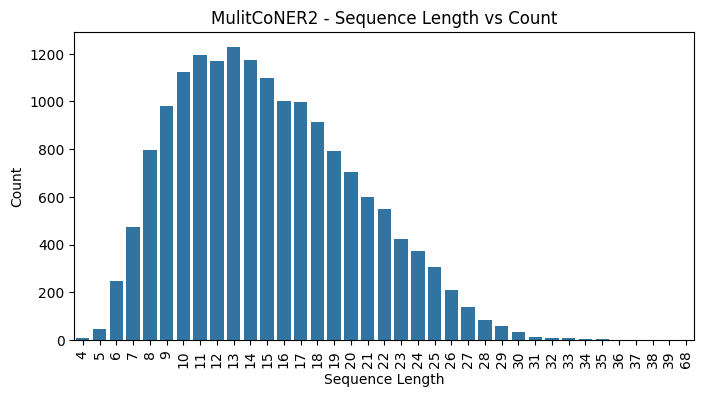

In [97]:
# Token length v/s Count Distribution for MulitCoNER2 Dataset
token_len_2_count_plot(data=multiconer2_dataset.train_data)

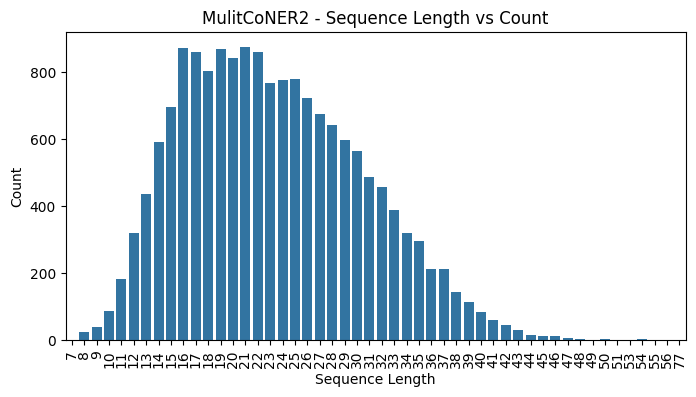

In [98]:
# Token length v/s Count Distribution for MulitCoNER2 Dataset (using transformers tokenizer)
token_len_2_count_plot(data=multiconer2_dataset.train_data, tokenize=True)

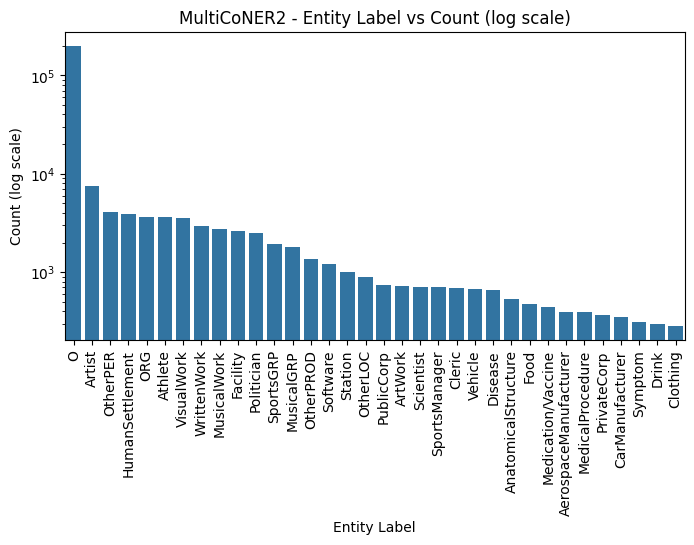

In [100]:
# Token length v/s Count Distribution for MulitCoNER2 Dataset
label_2_count_plot(data=multiconer2_dataset.train_data)

---
##### Bayesian Optimization

In [33]:
# ------------------------------------------- # Bayesian Optimization # ------------------------------------------- #

In [57]:
# ------------------------------------------- #  Hyperparamter space (Λ) for transformers # ------------------------------------------- #

In [58]:
thp_space = [Integer(10, 100, name='max_sequence_len'),
             Integer(1, 16, name='batch_size'),
             Integer(1, 10, name='num_epochs'),
             Real(1e-6, 1e-2, name='learning_rate', prior='log-uniform'),
             Real(1e-6, 1e-2, name='weight_decay', prior='log-uniform')]

In [59]:
# ------------------------------------------- #  Objective functions for transformers # ------------------------------------------- #

In [60]:
@use_named_args(thp_space)
def t_objective_fxn(max_sequence_len: int, batch_size: int, num_epochs: int,
                    learning_rate: float, weight_decay: float) -> Optional[float]:
    start_time = time.time()

    logging.info("Starting (transformers) objective function execution.")
    logging.info("Received attributes: batch_size={}, num_epochs={}, max_sequence_len={}, learning_rate={}, weight_decay={}".format(batch_size, num_epochs, max_sequence_len, learning_rate, weight_decay))

    logging.info("Initializing Tokenizer: AutoTokenizer.from_pretrained('xlm-roberta-base')")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
    logging.info("Tokenizer initialized successfully.")

    logging.info("Preparing NER Dataset: NERDataset_transformers(tokenizer=tokenizer, config=config_data, max_sequence_len=max_sequence_len)")
    ner_dataset = NERDataset_transformers(tokenizer=tokenizer, config=transformers_config_data, max_sequence_len=max_sequence_len)
    ner_dataset.on_setup()
    logging.info("NER Dataset prepared successfully.")

    logging.info("Initializing Model: XLMRobertaForTokenClassification.from_pretrained('xlm-roberta-base', num_labels=len(ner_dataset.dataset.labels))")
    model = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=len(ner_dataset.dataset.labels))
    model.to(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    logging.info("Model initialized successfully.")

    logging.info("Training...")
    trainer = Transformer_Trainer(model=model,
                                  dataset=ner_dataset,
                                  batch_size=batch_size,
                                  num_epochs=num_epochs,
                                  learning_rate=learning_rate,
                                  weight_decay=weight_decay)
    trainer.train(save=False)
    logging.info("Training completed.")

    logging.info("Evaluation...")
    results = trainer.get_valid_scores(dataloader=trainer.valid_dataloader,
                                       desc="Empirical Risk Calculation on Validation Data")
    logging.info("Measured `f1` score: {}".format(results["f1"]))
    logging.info("Evaluation completed.")

    del tokenizer
    del ner_dataset
    del model
    del trainer
    gc.collect()
    torch.cuda.empty_cache()

    end_time = time.time()
    execution_time = end_time - start_time
    logging.info("Objective function execution completed in {:.2f} seconds.".format(execution_time))

    return -results["f1"]

In [64]:
loaded_res_gp_t = skopt.load("./optimization_results_t.pkl")

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence, plot_objective, plot_evaluations, plot_regret

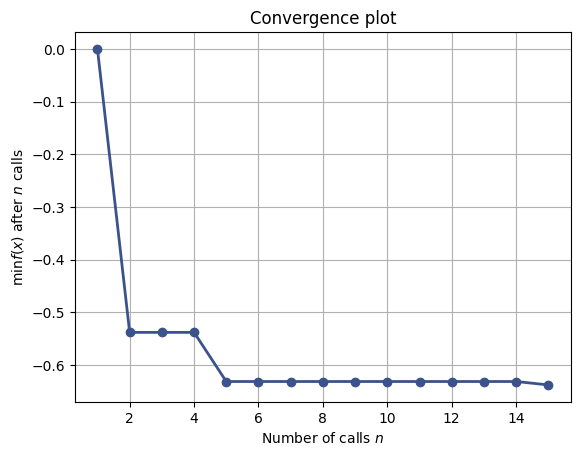

In [66]:
# Plot convergence using loaded results
plot_convergence(loaded_res_gp_t)
plt.show()

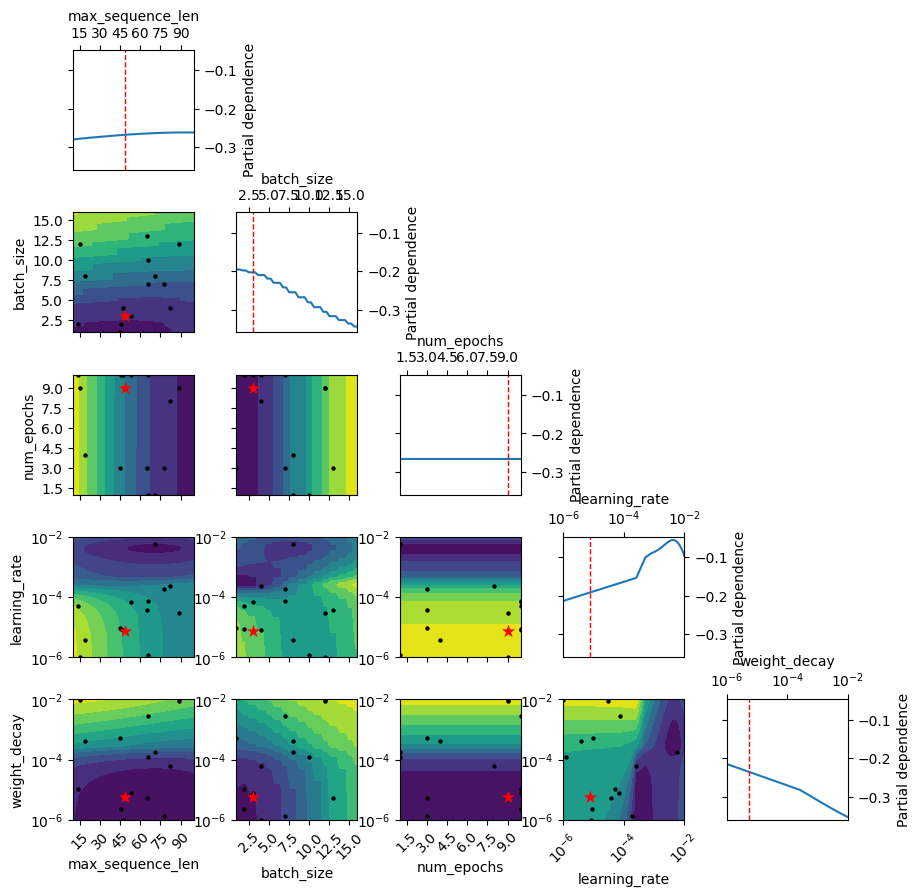

In [67]:
# Plot objective using loaded results
plot_objective(loaded_res_gp_t)
plt.show()

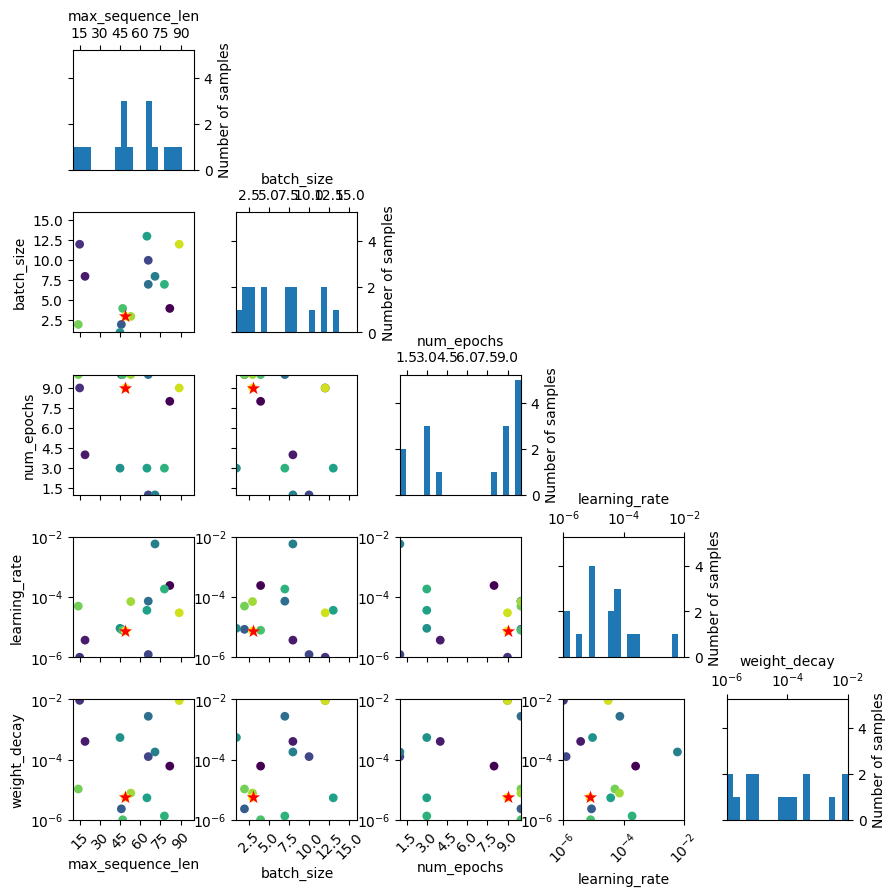

In [68]:
# Plot evaluations using loaded results
plot_evaluations(loaded_res_gp_t)
plt.show()

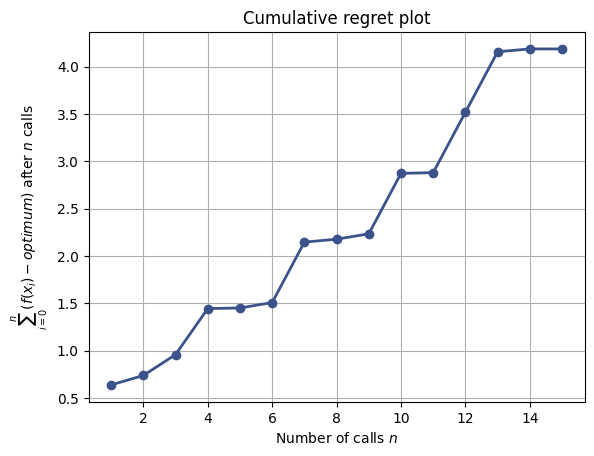

In [69]:
# Plot regret using loaded results
plot_regret(loaded_res_gp_t)
plt.show()

In [ ]:
# ------------------------------------------- # Hyperparameter space (Λ) for LSTM (`no CNN`) # ------------------------------------------- #

In [ ]:
lchp_space = [Integer(10, 100, name='max_sequence_len'),
              Integer(1, 16, name='batch_size'),
              Integer(1, 10, name='num_epochs'),
              Categorical(categories=[50, 100, 200, 300], name='input_dim'),
              Categorical(categories=[64, 128, 256, 512, 768], name='hidden_dim'),
              Integer(1, 5, name="n_layers"),
              Real(0.0, 0.5, name='dropout'),
              Real(1e-6, 1e-2, name='learning_rate', prior='log-uniform'),
              Real(1e-6, 1e-2, name='weight_decay', prior='log-uniform')]

In [44]:
# ------------------------------------------- # Objective function for LSTM (`no CNN`) # ------------------------------------------- #

In [54]:
@use_named_args(lchp_space)
def lc_objective_fxn(max_sequence_len: int, batch_size: int, num_epochs: int,
                     input_dim: int, hidden_dim: int, n_layers: int, dropout: float,
                     learning_rate: float, weight_decay: float) -> Optional[float]:
    start_time = time.time()

    logging.info("Starting (lstm-cnn) objective function execution.")
    logging.info("Received attributes: batch_size={}, num_epochs={}, max_sequence_len={}, input_dim: {}, hidden_dim: {}, n_layer: {}, dropout: {}, learning_rate={}, weight_decay={}".format(batch_size, num_epochs, max_sequence_len, input_dim, hidden_dim, n_layers, dropout, learning_rate, weight_decay))

    logging.info("Preparing NER Dataset: NERDataset_lstm_cnn(config=config_data, glove_dim=input_dim)")
    ner_dataset = NERDataset_lstm_cnn(config=lstm_cnn_config_data, glove_dim=input_dim)
    ner_dataset.on_setup()
    logging.info("NER Dataset prepared successfully.")

    logging.info("Preparing model configuration dict: prepare_model_config(**kwargs)")
    lstm_cnn_model_config = prepare_model_config(ner_dataset=ner_dataset,
                                                 feature_extractor="lstm",
                                                 dropout=dropout,
                                                 input_dim=input_dim,
                                                 hidden_dim=hidden_dim,
                                                 n_layers=n_layers)
    logging.info("Model configuration dict prepared successfully.")

    logging.info("Initializing Model: LSTMCNNForTokenClassification(config=lstm_cnn_model_config)")
    model = LSTMCNNForTokenClassification(config=lstm_cnn_model_config)
    model.to(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    logging.info("Model initialized successfully.")

    logging.info("Training...")
    trainer = LSTM_CNN_Trainer(model=model,
                               dataset=ner_dataset,
                               batch_size=batch_size,
                               num_epochs=num_epochs,
                               learning_rate=learning_rate,
                               weight_decay=weight_decay)
    trainer.train(save=False)
    logging.info("Training completed.")

    logging.info("Evaluation...")
    results = trainer.get_valid_scores(dataloader=trainer.valid_dataloader,
                                       desc="Empirical Risk Calculation on Validation Data")
    logging.info("Measured `f1` score: {}".format(results["f1"]))
    logging.info("Evaluation completed.")

    del ner_dataset
    del model
    del trainer
    gc.collect()
    torch.cuda.empty_cache()

    end_time = time.time()
    execution_time = end_time - start_time
    logging.info("Objective function execution completed in {:.2f} seconds.".format(execution_time))

    return -results["f1"]


In [ ]:
# ------------------------------------------- # Main Optimization Calls # ------------------------------------------- #

In [62]:
import logging

# Set up logging to file and console
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
file_handler = logging.FileHandler('logfile_bayesopt.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(file_handler)

In [46]:
# Uncomment this to run `bayesian-optimization`
if __name__ == "__main__":
    modeling_type = general_config_data["MODELING_TYPE"]
    if modeling_type == "transformers":
        logging.info("Start: scikit-optimize `Gaussian-Process` optimization procedure.")
        res_gp = gp_minimize(t_objective_fxn, thp_space, n_calls=15, random_state=42, callback=[DeltaXStopper(0.001)])
        logging.info("End: scikit-optimize `Gaussian-Process` optimization procedure.")

        best_hyperparams = res_gp.x
        # logging.info("Best Hyperparameters: ", best_hyperparams)
        print(best_hyperparams)

        save_skopt_results(res_gp, logging=logging)

    elif modeling_type == "lstm_cnn":
        logging.info("Start: scikit-optimize `Gaussian-Process` optimization procedure.")
        res_gp = gp_minimize(lc_objective_fxn, lchp_space, n_calls=15, random_state=42, callback=[DeltaXStopper(0.001)])
        logging.info("End: scikit-optimize `Gaussian-Process` optimization procedure.")

        best_hyperparams = res_gp.x
        # logging.info("Best Hyperparameters: ", best_hyperparams)
        print(best_hyperparams)

        save_skopt_results(res_gp, logging=logging)

-----
##### Main

In [ ]:
# ------------------------------------------- # MAIN # ------------------------------------------- #

`XLMRobertaForTokenClassification`

**Total-Parameters**

```
Total number of parameters: 277506117
Total number of trainable parameters: 277506117
```

**Hyperparameters**

```
BATCH_SIZE: 3
NUM_EPOCHS: 9
MAX_SEQUENCE_LEN: 49
LEARNING_RATE: 7.532159062843439e-06
WEIGHT_DECAY: 5.533135829935303e-06
EARLY_STOPPING_THRESHOLD: 5
```

`LSTMCNNForTokenClassification`

**Total-Parameters**

```
Total number of parameters: 128570325
Total number of trainable parameters: 128570325
```

**Hyperparameters**

```
BATCH_SIZE: 6
NUM_EPOCHS: 6
INPUT_DIM: 200
N_LAYERS: 4
HIDDEN_DIM: 768
DROPOUT: 0.3736600550686905
MAX_SEQUENCE_LEN: 75
LEARNING_RATE: 0.00014413469371110337
WEIGHT_DECAY: 0.00022233337605920384
EARLY_STOPPING_THRESHOLD: 5
```

In [ ]:
# Set up logging to file and console
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
file_handler = logging.FileHandler('logfile_main.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(file_handler)

In [103]:
model = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base",
                                                                    num_labels=69)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
print_model_details(model)

Total number of parameters: 277506117
Total number of trainable parameters: 277506117


In [105]:
if __name__ == "__main__":

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    logger.info(f"Using device: {device}")

    modeling_type = general_config_data["MODELING_TYPE"]
    logger.info(f"Modeling type: {modeling_type}")

    if modeling_type == "transformers":

        model_checkpoint = transformers_config_data["MODEL_CHECKPOINT"]
        logger.info(f"Model checkpoint: {model_checkpoint}")

        tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,
                                                  add_prefix_space=True)  # specific to XLM-RoBERTa
        logger.info("Tokenizer loaded")

        ner_dataset = NERDataset_transformers(tokenizer=tokenizer, config=transformers_config_data)
        logger.info("NER Dataset created")

        ner_dataset.on_setup()
        logger.info("Using TokenClassification model")
        model = XLMRobertaForTokenClassification.from_pretrained(model_checkpoint,
                                                                    num_labels=len(ner_dataset.dataset.labels))
        model.to(device)
        print_model_details(model)

        logger.info("Training...")
        trainer = Transformer_Trainer(
            model=model,
            dataset=ner_dataset
        )
        logger.info("Trainer initialized")
        trainer.train(use_patience=False)
        logger.info("Training completed")

        logging.info("Evaluation...")
        results = trainer.get_valid_scores(dataloader=trainer.valid_dataloader,
                                           desc="Empirical Risk Calculation on Validation Data")
        logging.info("Measured `f1` score: {}, `accuracy` score: {}".format(results["f1"], results["accuracy"]))
        logging.info("Evaluation completed.")

    elif modeling_type == "lstm_cnn":
        feature_extractor = lstm_cnn_config_data["FEATURE_EXTRACTOR"]
        logger.info(f"Feature extractor utilized: {feature_extractor}")

        ner_dataset = NERDataset_lstm_cnn(config=lstm_cnn_config_data,
                                          glove_dim=lstm_cnn_config_data["INPUT_DIM"])
        ner_dataset.on_setup()
        logger.info("NER Dataset created")

        lstm_cnn_model_config = prepare_model_config(ner_dataset=ner_dataset)

        print(lstm_cnn_model_config)

        logger.info("Using TokenClassification model")
        model = LSTMCNNForTokenClassification(config=lstm_cnn_model_config)
        model.to(device)
        print_model_details(model)

        logger.info("Training...")
        trainer = LSTM_CNN_Trainer(model=model,
                                   dataset=ner_dataset)

        logger.info("Trainer initialized")
        trainer.train(use_patience=False)
        logger.info("Training completed")

        logging.info("Evaluation...")
        results = trainer.get_valid_scores(dataloader=trainer.valid_dataloader,
                                           desc="Empirical Risk Calculation on Validation Data")
        logging.info("Measured `f1` score: {}, `accuracy` score: {}".format(results["f1"], results["accuracy"]))
        logging.info("Evaluation completed.")

-----
##### Evaluation Results

In [106]:
metric_types_ = ["precision", "recall", "f1", "accuracy"]
class NER_Evaluation:
    def __init__(self, model, dataset, data_type: data_types_="valid", modeling_type="transformers"):
        super(NER_Evaluation, self).__init__()

        self.model = model
        self.dataset = dataset
        self.data_type = data_type
        self.modeling_type = modeling_type

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self._on_setup()

    def _on_setup(self):
        results, (true_predictions, true_labels) = self._generate_results()
        self.results = results
        self.true_predictions = true_predictions
        self.true_labels = true_labels
        self.results_df = self._tabularize_results()

    def _generate_results(self):
        predictions = []
        ground_truth = []
        data_loader = self.dataset.set_up_dataloader(data_type=self.data_type)
        for batch in tqdm(data_loader):
            if self.modeling_type == "transformers":
                input_ids, attention_mask, labels, _ = batch
                outputs = self.model(input_ids=input_ids,
                                    attention_mask=attention_mask)
                probabilities = F.softmax(outputs.logits, dim=-1)
                batch_predictions = probabilities.argmax(dim=-1).to("cpu").tolist()
                predictions.extend(batch_predictions)
                ground_truth.extend(labels.to("cpu").tolist())
            elif self.modeling_type == "lstm_cnn":
                word_ids, labels, _, mask = batch
                outputs = self.model(word_ids=word_ids)
                probabilities = F.softmax(outputs.logits, dim=-1)
                batch_predictions = probabilities.argmax(dim=-1).to("cpu").tolist()
                predictions.extend(batch_predictions)
                ground_truth.extend(labels.to("cpu").tolist())

        del probabilities
        del batch_predictions
        gc.collect()

        torch.cuda.empty_cache()
        results, (true_predictions, true_labels) = get_scores((predictions, ground_truth),
                                                              ner_labels_list=self.dataset.dataset.labels,
                                                              full_rep=True)
        return results, (true_predictions, true_labels)

    def _tabularize_results(self):
        results_dict = defaultdict(list)
        for key in self.results.keys():
            if key in ["overall_precision", "overall_recall", "overall_f1", "overall_accuracy"]:
                continue
            results_dict["entity"].append(key)
            results_dict["precision"].append(self.results[key]["precision"])
            results_dict["recall"].append(self.results[key]["recall"])
            results_dict["f1"].append(self.results[key]["f1"])
            results_dict["number"].append(self.results[key]["number"])
        return pd.DataFrame(results_dict)

    def plot_evaluation_metric(self, metric: metric_types_, figsize=(8, 4), rotation=90):
        self.results_df[metric].plot(kind='line', figsize=figsize, title=metric.capitalize(), marker='', linestyle='-')
        self.results_df[metric].plot(kind='line', marker='o', color='red', linestyle='None')
        plt.gca().spines[['top', 'right']].set_visible(False)
        plt.xticks(range(len(self.results_df)), self.results_df['entity'], rotation=rotation)
        plt.xlabel('Entity')
        plt.ylabel(metric.capitalize())
        plt.show()

    def get_aggregated_entities(self):
        return {
            "Medical": ["Disease", "Symptom", "AnatomicalStructure", "MedicalProcedure", "Medication/Vaccine"],
            "Product": ["OtherPROD", "Drink", "Food", "Vehicle", "Clothing"],
            "Person": ["OtherPER", "SportsManager", "Cleric", "Politician", "Athlete", "Artist", "Scientist"],
            "Group": ["MusicalGRP", "PublicCorp", "PrivateCorp", "AerospaceManufacturer", "SportsGRP", "CarManufacturer", "ORG"],
            "Creative Works": ["VisualWork", "MusicalWork", "WrittenWork", "ArtWork", "Software"],
            "Location": ["Facility", "OtherLOC", "HumanSettlement", "Station"]
        }

    # visualization using t-SNE only limited to transformers based models
    def visualize_entities(self, aggregate_categories: bool=False):
        def process_batch(batch):
            input_ids, attention_mask, labels, mask = batch
            outputs = self.model(input_ids=input_ids,
                                 attention_mask=attention_mask,
                                 labels=labels,
                                 output_hidden_states=True)
            last_hidden_state = outputs.hidden_states[-1]
            return last_hidden_state, labels

        def find_aggregate_category(label: str):
            aggregated_entities_dict = self.get_aggregated_entities()
            for category, entity_list in aggregated_entities_dict.items():
                if label in entity_list:
                    return category
            return label

        dataloader = self.dataset.set_up_dataloader(data_type=self.data_type, batch_size=1)
        all_last_hidden_states = []
        all_labels = []

        with torch.no_grad():
            pbar = tqdm(dataloader, desc="Validation Data Iteration")
            for step, batch in enumerate(pbar):
                batch = tuple(t.to(self.device) for t in batch)
                last_hidden_state, labels = process_batch(batch)
                all_last_hidden_states.append(last_hidden_state)
                all_labels.append(labels)

        all_labelwise_embeddings = []
        for labels, last_hidden_state in tqdm(zip(all_labels, all_last_hidden_states), total=len(all_labels)):
            labels = labels.squeeze(0).tolist()
            last_hidden_state = last_hidden_state.squeeze(0)
            current_tag = None
            current_id = None
            current_sum = None
            count = 0
            for index, label_id in enumerate(labels):
                if label_id == -100 or label_id == 68:
                    continue
                tag = self.dataset.dataset.idx2labels[label_id].split("-")[-1].strip()
                if label_id != current_id and tag != current_tag:
                    if current_id is not None:
                        averaged_embedding = current_sum / count
                        all_labelwise_embeddings.append((tag, averaged_embedding))
                    current_tag = tag
                    current_id = label_id
                    current_sum = last_hidden_state[index]
                    count = 1
                elif label_id != current_id and tag == current_tag:
                    current_id = label_id
                    current_sum += last_hidden_state[index]
                    count += 1
                else:
                    current_sum += last_hidden_state[index]
                    count += 1
            if current_id is not None:
                averaged_embedding = current_sum / count
                all_labelwise_embeddings.append((tag, averaged_embedding))

        entity_tags_list, entity_embeddings_list = zip(*all_labelwise_embeddings)

        entity_embeddings = torch.stack(entity_embeddings_list)
        entity_embeddings = entity_embeddings.detach().to("cpu").numpy()

        tsne = TSNE(n_components=2, random_state=42)
        embeddings_transform = tsne.fit_transform(entity_embeddings)

        embeddings_transform_df = pd.DataFrame(embeddings_transform, columns=["Dimension 1", "Dimension 2"])
        embeddings_transform_df["label"] = entity_tags_list

        if aggregate_categories:
            embeddings_transform_df["label"] = embeddings_transform_df.apply(
                lambda row: find_aggregate_category(row["label"]),
                axis=1
            )

        plt.figure(figsize=(12, 10))
        sns.scatterplot(data=embeddings_transform_df,
                        x="Dimension 1",
                        y="Dimension 2",
                        hue="label",
                        palette="tab20",
                        markers="o",
                        s=100,
                        legend="full")
        plt.title("t-SNE Cluster Representation")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

In [107]:
# ------------------------------------------- # Evaluating transformers # ------------------------------------------- #

TODO: CREATE A TABLE WITH OVERALL PRECISION, RECALL, F1, ACCURACY SCORES

SEQEVAL HAS OPTION FOR CLASSIFICATION REPORT SEE IF WE CAN USE IT AND DERIVE MICRO, MACRO AND WEIGHTED F1 SCORES

In [108]:
%%capture
transformer_model_checkpoint = "./model_checkpoints/transformers/xlm-roberta-base_v1_20240316042411/"

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

ner_dataset_t = NERDataset_transformers(tokenizer=tokenizer,
                                      config=transformers_config_data)
ner_dataset_t.on_setup()

transformer_model = XLMRobertaForTokenClassification.from_pretrained(transformer_model_checkpoint)
transformer_model.to(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

In [110]:
transformers_evaluation = NER_Evaluation(model=transformer_model,
                                         dataset=ner_dataset_t,
                                         data_type="valid",
                                         modeling_type="transformers")

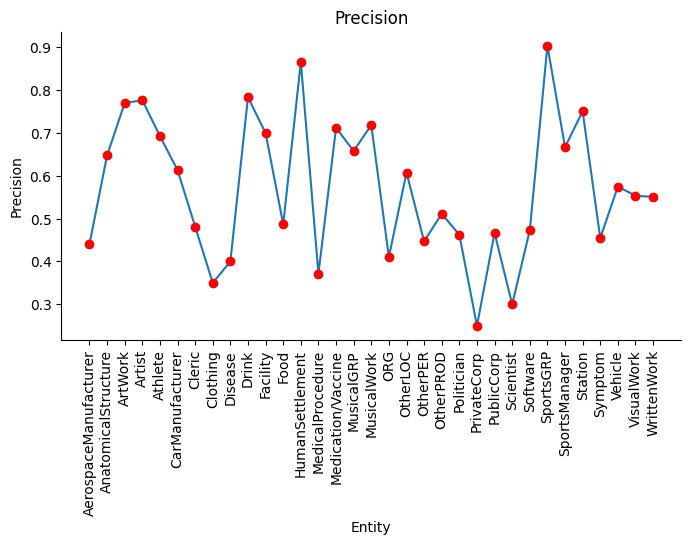

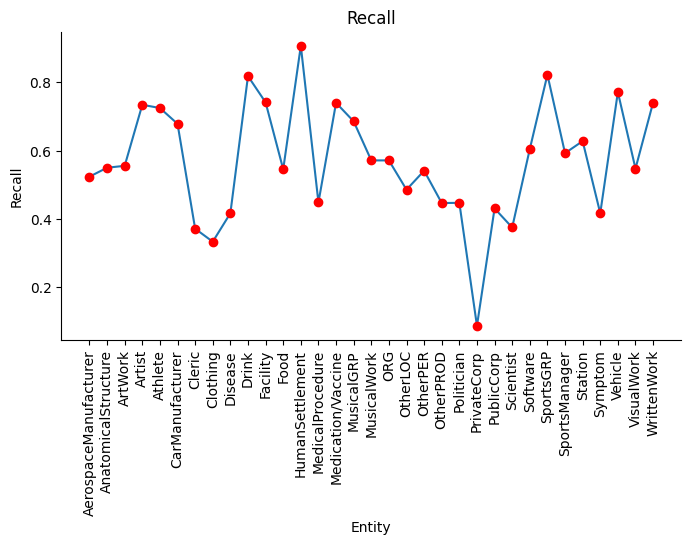

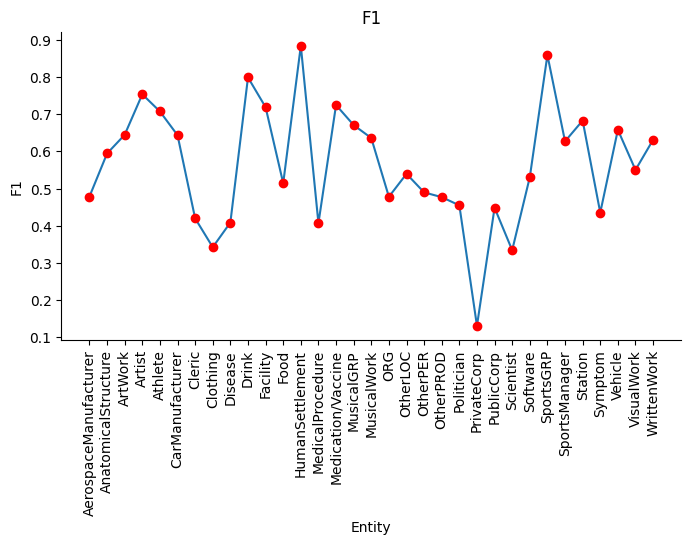

In [ ]:
transformers_evaluation.plot_evaluation_metric('precision')
transformers_evaluation.plot_evaluation_metric('recall')
transformers_evaluation.plot_evaluation_metric('f1')

Validation Data Iteration:   0%|          | 0/871 [00:00<?, ?it/s]

  0%|          | 0/871 [00:00<?, ?it/s]

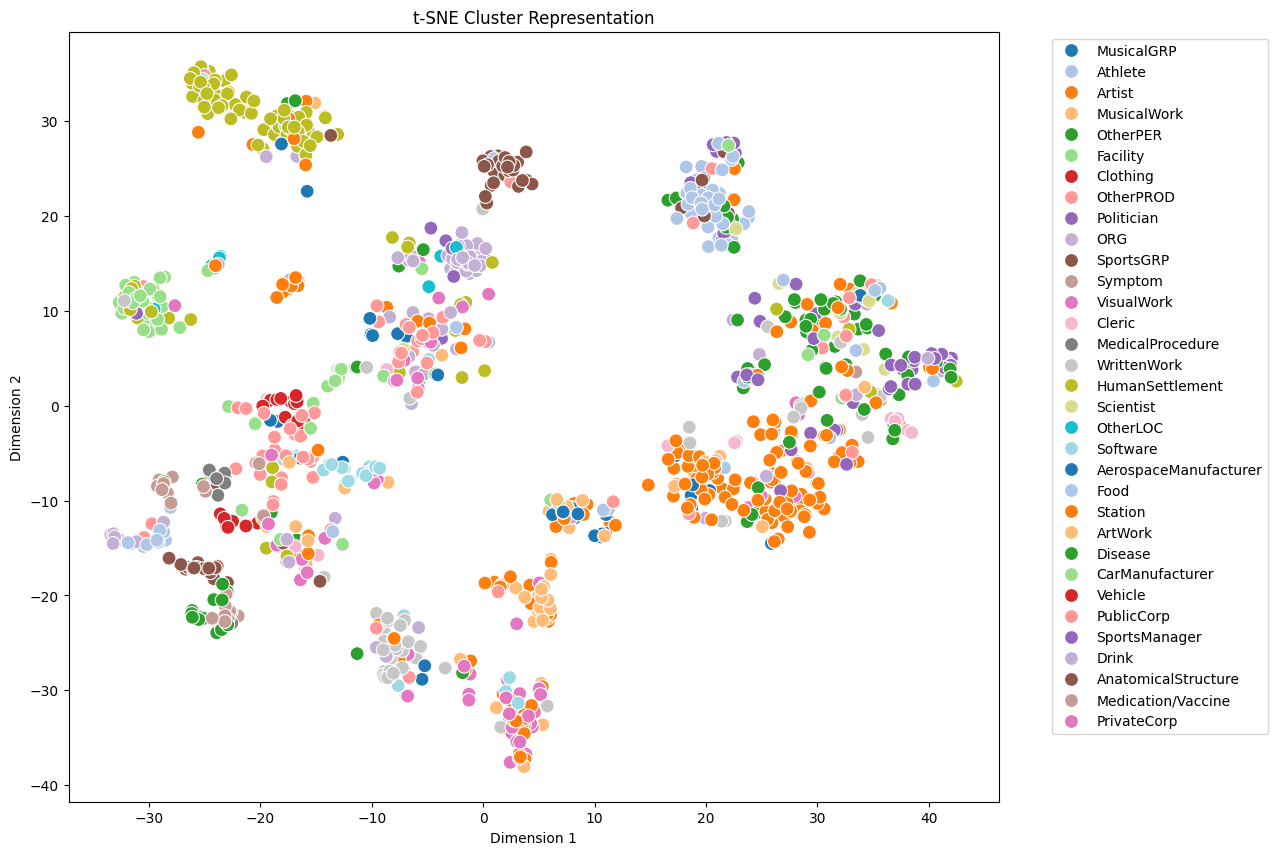

In [ ]:
transformers_evaluation.visualize_entities(aggregate_categories=False)

Validation Data Iteration:   0%|          | 0/871 [00:00<?, ?it/s]

  0%|          | 0/871 [00:00<?, ?it/s]

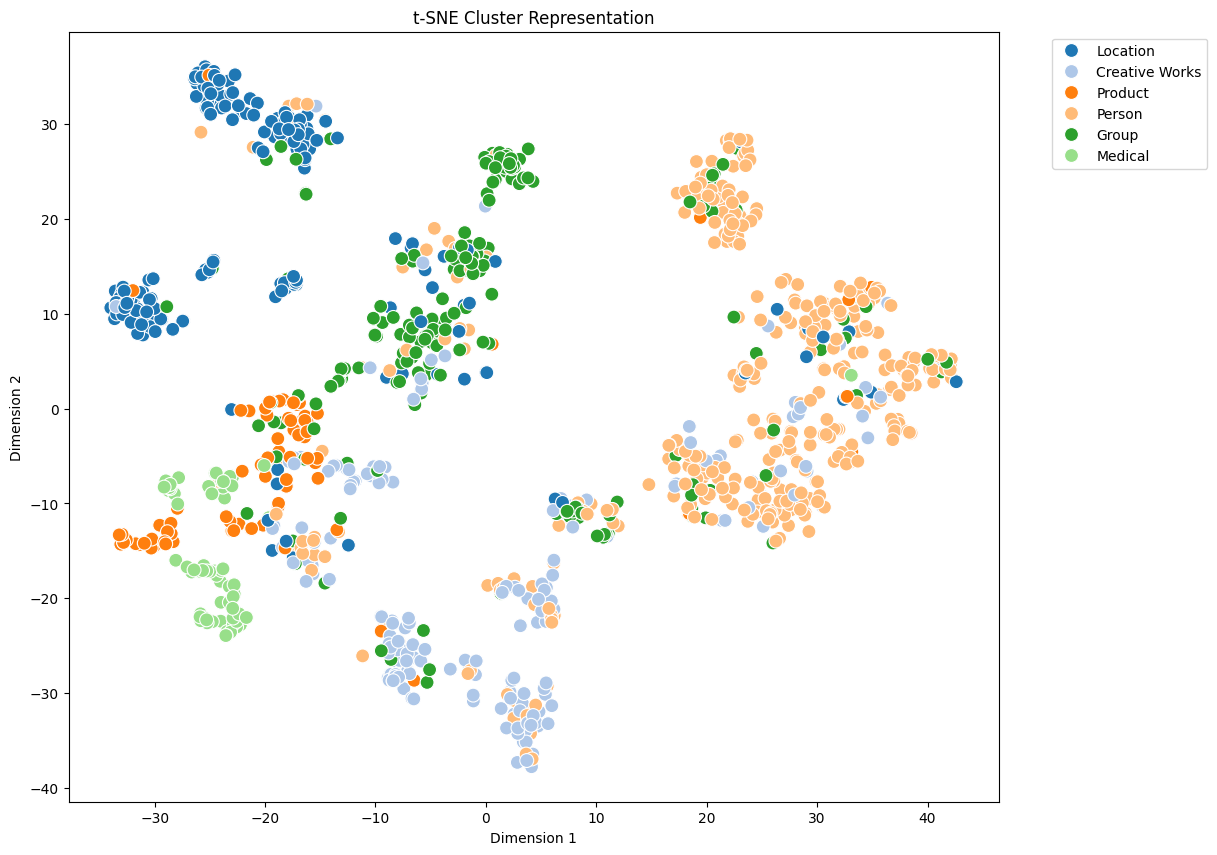

In [ ]:
transformers_evaluation.visualize_entities(aggregate_categories=True)

In [ ]:
transformers_evaluation = NER_Evaluation(model=transformer_model,
                                         dataset=ner_dataset_t,
                                         data_type="train",
                                         modeling_type="transformers")

  0%|          | 0/8389 [00:00<?, ?it/s]

Validation Data Iteration:   0%|          | 0/16778 [00:00<?, ?it/s]

  0%|          | 0/16778 [00:00<?, ?it/s]

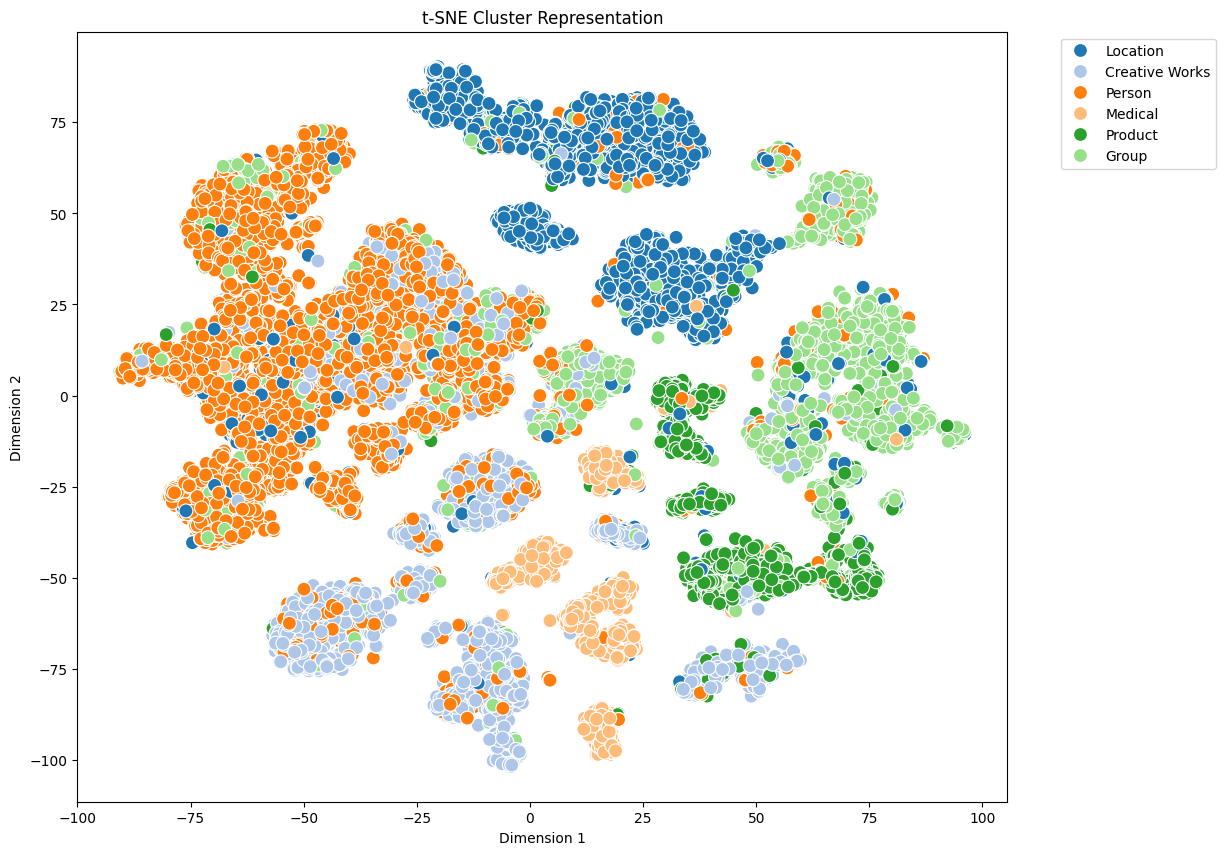

In [ ]:
transformers_evaluation.visualize_entities(aggregate_categories=True)

In [ ]:
# ------------------------------------------- # Evaluating LSTM # ------------------------------------------- #

In [ ]:
%%capture
model_checkpoint = "./lstm_20240316163011/model.pth"

ner_dataset_lc = NERDataset_lstm_cnn(config=lstm_cnn_config_data,
                                     glove_dim=lstm_cnn_config_data["INPUT_DIM"])
ner_dataset.on_setup()

lstm_cnn_model_config = prepare_model_config(ner_dataset=ner_dataset)

lstm_model = LSTMCNNForTokenClassification(config=lstm_cnn_model_config)
checkpoint = torch.load(model_checkpoint)
lstm_model.load_state_dict(checkpoint)

In [ ]:
lstmcnn_evaluation = NER_Evaluation(model=lstm_model,
                                    dataset=ner_dataset_lc,
                                    data_type="valid",
                                    modeling_type="lstm_cnn")

  0%|          | 0/436 [00:00<?, ?it/s]

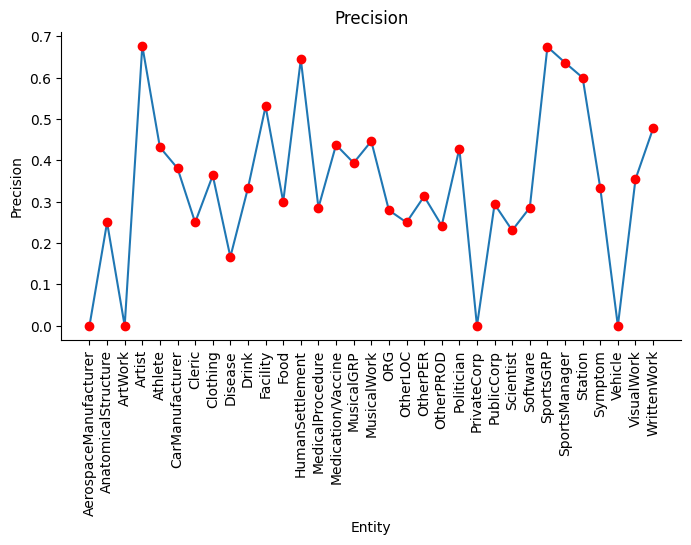

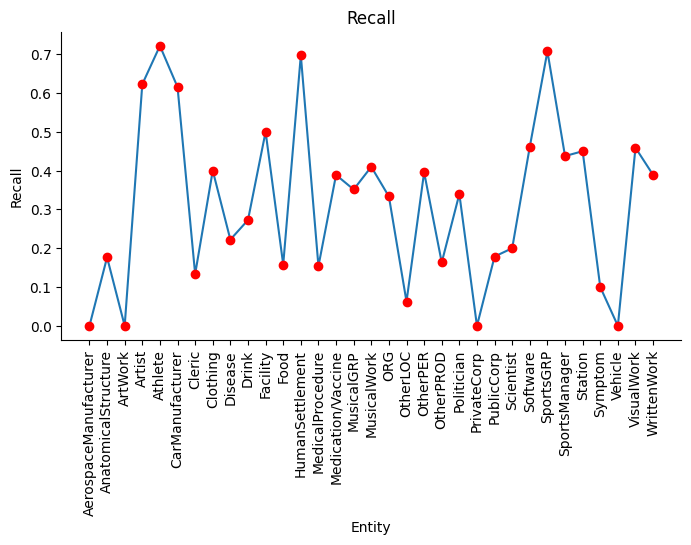

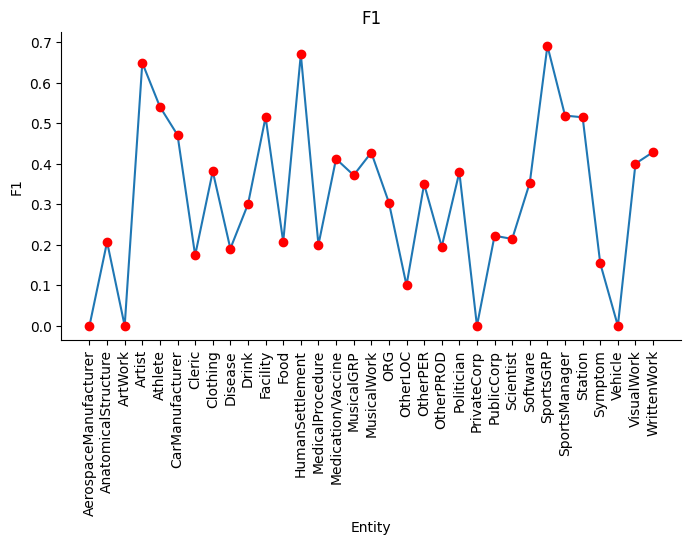

In [ ]:
lstmcnn_evaluation.plot_evaluation_metric('precision')
lstmcnn_evaluation.plot_evaluation_metric('recall')
lstmcnn_evaluation.plot_evaluation_metric('f1')

In [ ]:
# ------------------------------------------- # Comparison # ------------------------------------------- #

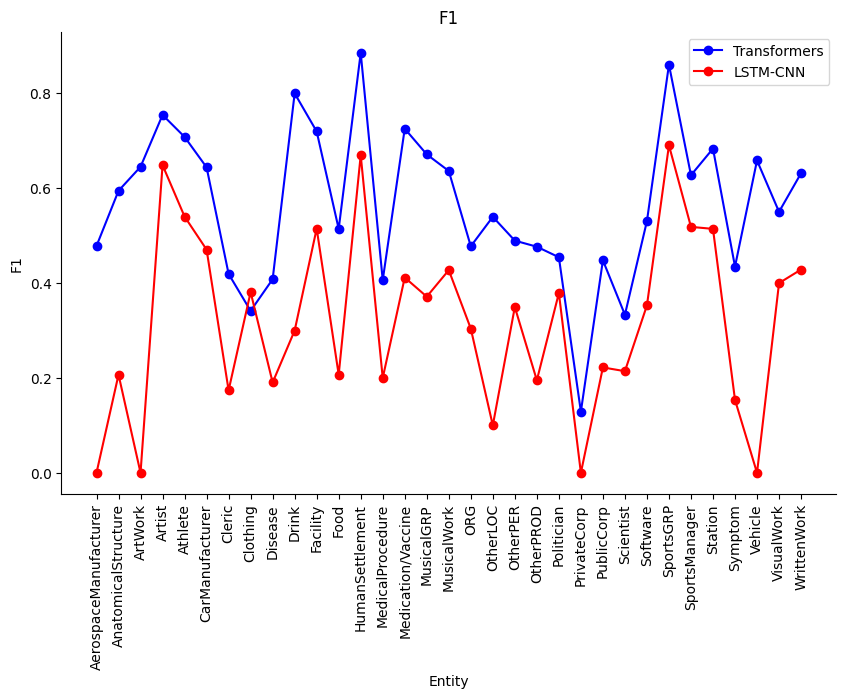

In [ ]:
metric = "f1"
figsize = (10, 6)
rotation = 90

transformers_evaluation.results_df[metric].plot(kind='line', figsize=figsize, title=metric.capitalize(), marker='o', color='blue', linestyle='-')

lstmcnn_evaluation.results_df[metric].plot(kind='line', marker='o', color='red', linestyle='-')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xticks(range(len(transformers_evaluation.results_df)), transformers_evaluation.results_df['entity'], rotation=rotation)
plt.xlabel('Entity')
plt.ylabel(metric.capitalize())
plt.legend(['Transformers', 'LSTM-CNN'])

----
##### Attention Visualization

In [ ]:
general_config_data = load_from_yaml("./configurations/config.yaml")
transformers_config_data = load_from_yaml("./configurations/transformers_config.yaml")
lstm_cnn_config_data = load_from_yaml("./configurations/lstm_cnn_config.yaml")

In [ ]:
model_checkpoint = "./model_checkpoints/transformers/xlm-roberta-base_v1_20240316042411/"

In [ ]:
%%capture
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

ner_dataset = NERDataset_transformers(tokenizer=tokenizer, config=transformers_config_data)
ner_dataset.on_setup()

model = XLMRobertaForTokenClassification.from_pretrained(model_checkpoint)

In [ ]:
sample_instance = ner_dataset.dataset.valid_data.sample(n=1).iloc[0]
sample_text = sample_instance["tokens"]
sample_labels = sample_instance["labels"]
print(sample_text, sample_labels)

['the', 'iron', 'sheik', '(', 'orange', 'or', 'yellow', 'designs', 'on', 'tights', ')'] ['B-Athlete', 'I-Athlete', 'I-Athlete', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
input_text = sample_text
target_word = "sheik"

In [ ]:
def plot_attentions(input_text: List[str],
                    target_word: str,
                    model: XLMRobertaForTokenClassification,
                    tokenizer: AutoTokenizer,
                    aggregate_heads: bool=False):
    if target_word not in input_text:
        raise ValueError("parameter `target_word` is not present in the provided `input_text`.")

    tokens = tokenizer.tokenize(input_text, is_split_into_words=True, add_special_tokens=True)
    encodings = tokenizer(input_text, is_split_into_words=True)
    word_ids = encodings.word_ids()
    # index of `target_word` in `input_text` (original)
    target_word_idx = input_text.index(target_word)
    # index(s) of tokenized `target_word` in tokenized representation
    target_word_new_idxs = [index for index, word_id in enumerate(word_ids) if word_id == target_word_idx]

    # compute output_attentions & hidden_states
    with torch.no_grad():
        outputs = model(**tokenizer([input_text], return_tensors="pt", is_split_into_words=True), output_attentions=True)
        attentions = outputs.attentions
        attentions = torch.cat(attentions).to("cpu")

    attentions = attentions.permute(2, 1, 0, 3)
    layers = len(attentions[0][0])
    heads = len(attentions[0])
    seqlen = len(attentions)

    # attention weights corresponding to the `target_word` token index(s)
    attentions_pos = attentions[target_word_new_idxs]

    if not aggregate_heads:
        cols = 2
        rows = int(heads/cols)
        for index, pos in enumerate(target_word_new_idxs):
            attentions_pos_ = attentions_pos[index]
            fig, axes = plt.subplots(rows, cols, figsize=(15,35))
            axes = axes.flat
            print (f'Attention weights for token {tokens[pos]}')
            for i, att in enumerate(attentions_pos_):
                im = axes[i].imshow(att, cmap='gray')
                sns.heatmap(att, vmin=0, vmax=1, ax=axes[i], xticklabels=tokens)
                axes[i].set_title(f'head - {i} ' )
                axes[i].set_ylabel('layers')
            plt.show()
    else:
        plt.figure(figsize=(7,4))
        for index, pos in enumerate(target_word_new_idxs):
            print (f'Attention weights for token {tokens[pos]}')
            attentions_pos_ = attentions_pos[index]
            avg_attention = attentions_pos_.mean(dim=0)
            sns.heatmap(avg_attention, vmin=0, vmax=1, xticklabels=tokens)
            plt.show()

Attention weights for token ▁she


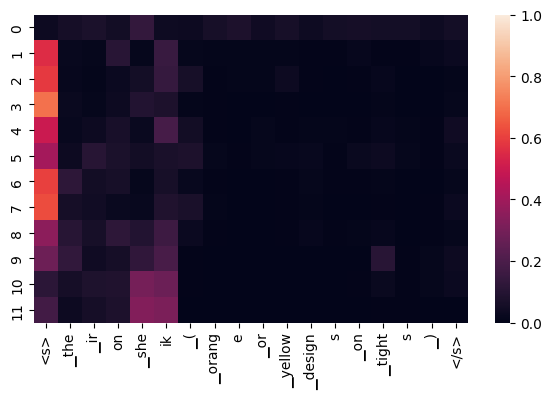

Attention weights for token ik


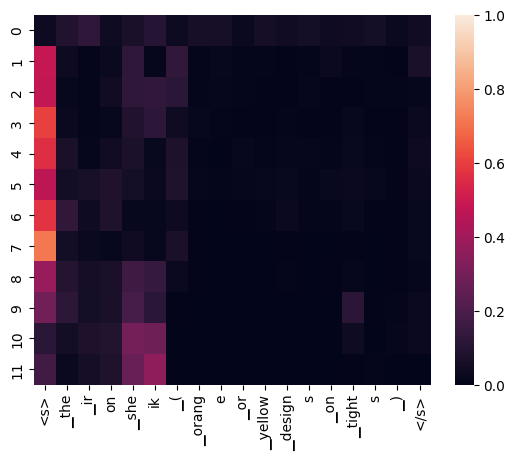

In [ ]:
plot_attentions(sample_text,
                target_word="sheik",
                model=model,
                tokenizer=tokenizer,
                aggregate_heads=True)

In [ ]:
# TODOs
# 1. t-SNE analysis later
# data analysis
# 3. pick random example to show the attention mechanism
# 2. correlation matrix after training
# 3. label distribution plot
# need to add <eos> token to the end before pad in preprocess func.